In [36]:
# Imports & Configs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
pd.options.display.float_format = '{:,.4f}'.format

In [37]:
# Load data file
df = pd.read_csv('sl_withmoon.csv')

In [38]:
# Orginize dataframe
df = df.drop(columns='Unnamed: 0')
df = df.rename(columns={"average":"atmosphere_co2"})

In [40]:
df.head()

,year,SeaLevel,atmosphere_co2,moon_phase_sin,moon_phase_cos,actual_year,month,month_sin,month_cos,Temperature,moon_phase
0,"1,992.9614",-14.7200,357.2100,0.0667,-0.9978,1992,12,-0.0000,1.0000,0.2200,14.4514
1,"1,992.9865",-19.3200,357.2100,0.0613,-0.9981,1992,12,-0.0000,1.0000,0.2200,14.4765
2,"1,993.0123",-22.1200,357.2100,0.0559,-0.9984,1993,1,0.5000,0.8660,0.3400,14.5023
3,"1,993.0406",-23.4200,357.2100,0.0499,-0.9988,1993,1,0.5000,0.8660,0.3400,14.5306
4,"1,993.0641",-24.7200,357.3005,0.0449,-0.9990,1993,1,0.5000,0.8660,0.3400,14.5541


In [4]:
df.shape

(1495, 11)

In [39]:
# Inconsistency in measurements across years 
df.actual_year.value_counts().sort_index().tail(10)

2015    37
2016    53
2017    51
2018    37
2019    37
2020    37
2021    49
2022    67
2023    74
2024    22
Name: actual_year, dtype: int64

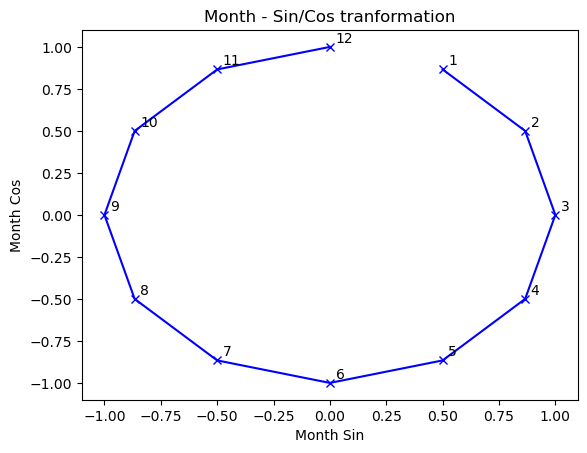

In [41]:
# Plot cyclical features
df_gb = df.groupby(['month']).mean()
x=df_gb['month_sin']
y=df_gb['month_cos']
plt.plot(x, y, 'b-',marker='x', label="month sin cos")
plt.title("Month - Sin/Cos tranformation")
plt.xlabel("Month Sin")
plt.ylabel("Month Cos")
for i,values in enumerate(zip(x, y)):
    plt.text(values[0]+0.025, values[1]+0.025, i+1)

plt.show()

In [8]:
df.columns

Index(['year', 'SeaLevel', 'atmosphere_co2', 'moon_phase_sin',
       'moon_phase_cos', 'actual_year', 'month', 'month_sin', 'month_cos',
       'Temperature', 'moon_phase'],
      dtype='object')

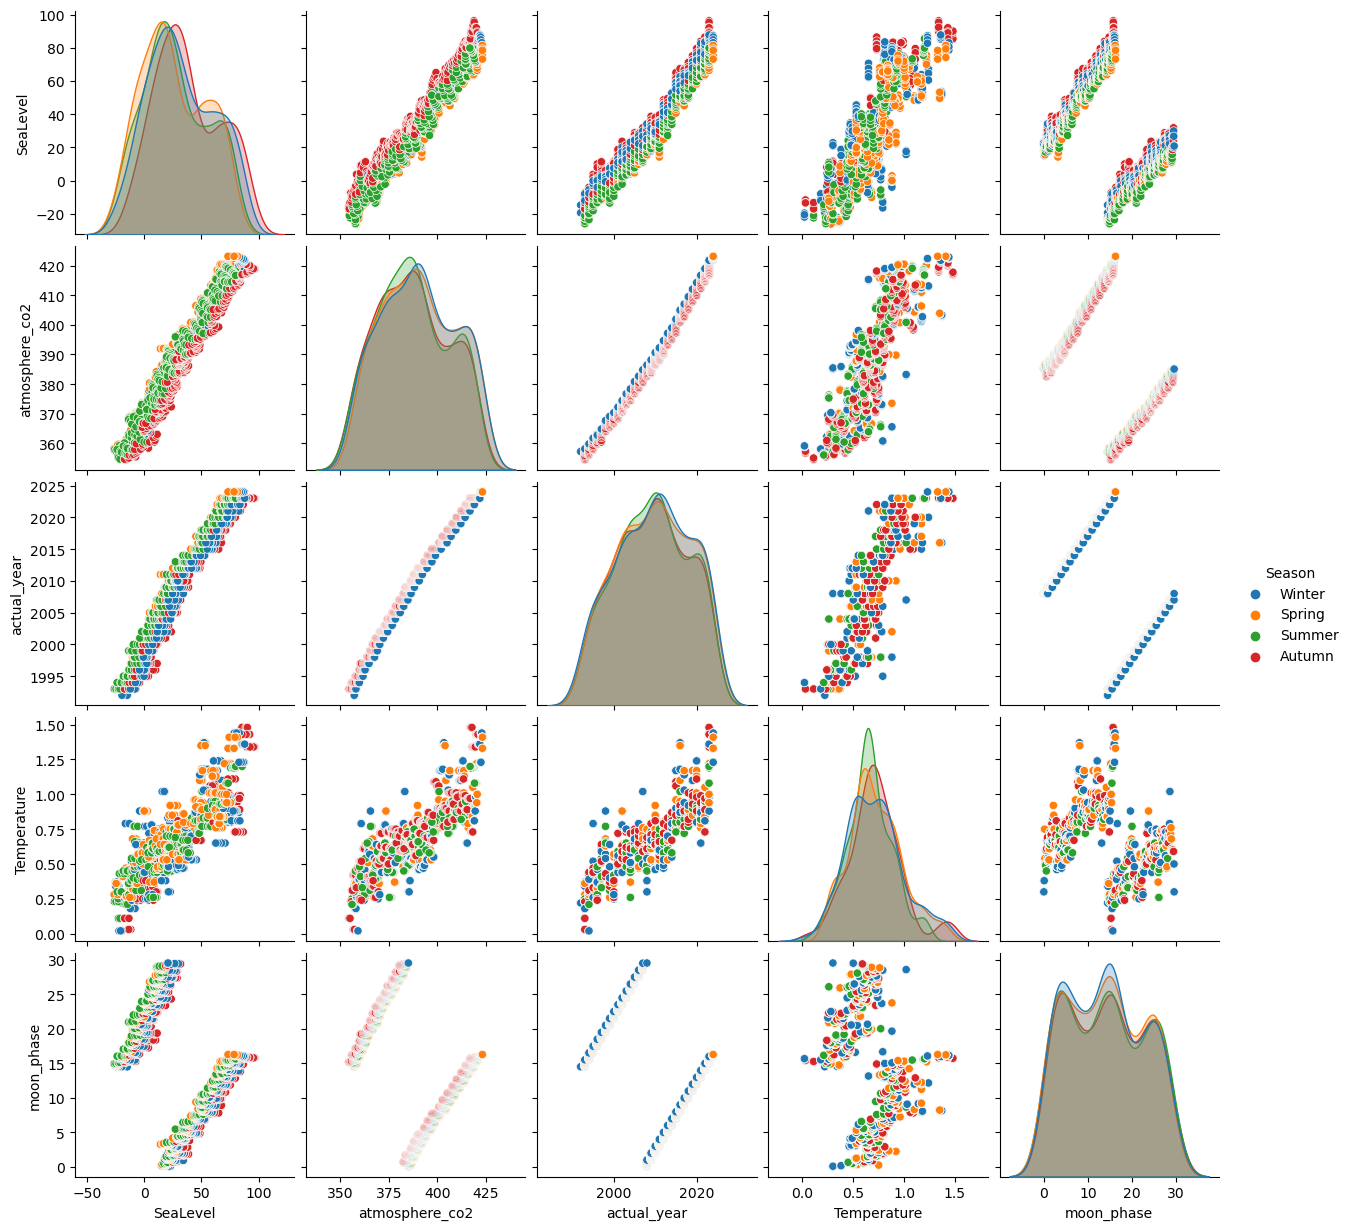

In [42]:
# Add season feature by month
df['Season'] = np.where(df.month.isin([12,1,2]), 'Winter',
                        np.where(df.month.isin([3,4,5]), 'Spring',
                                np.where(df.month.isin([6,7,8]), 'Summer', 'Autumn')))
showcols = ['SeaLevel', 'atmosphere_co2', 'actual_year', 'Season', 'Temperature', 'moon_phase']
sns.pairplot(data = df[showcols], hue="Season")

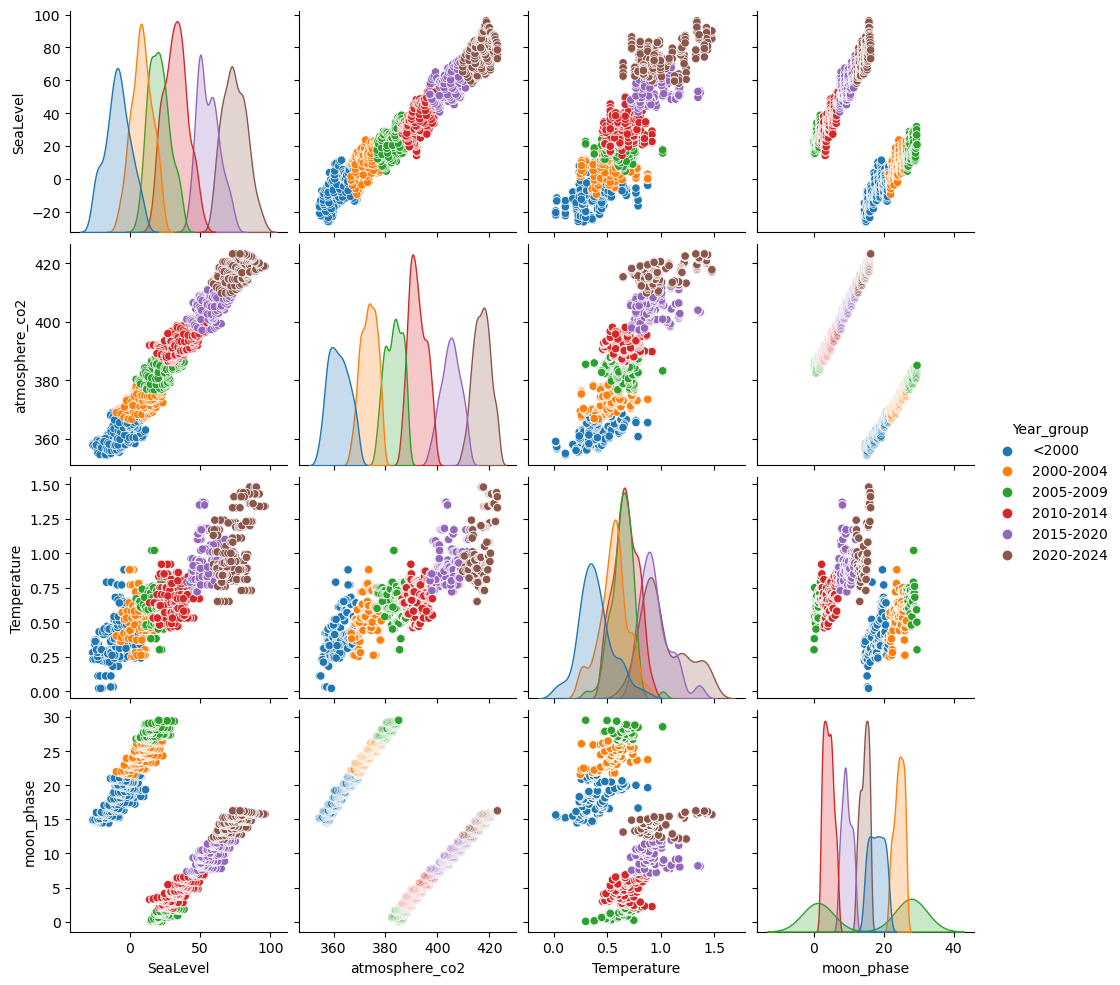

In [43]:
# Add Year group feature
df['Year_group'] = np.where(df.actual_year<2000, '<2000',
                        np.where(df.actual_year<2005, '2000-2004',
                            np.where(df.actual_year<2010, '2005-2009',
                                np.where(df.actual_year<2015, '2010-2014',
                                    np.where(df.actual_year<2020, '2015-2020', '2020-2024')))))
showcols = ['SeaLevel', 'atmosphere_co2', 'Year_group', 'Season', 'Temperature', 'moon_phase']
sns.pairplot(data = df[showcols], hue="Year_group")

## Check Normality

In [44]:
def check_normality(data, threshold=30):
    """
    Perform a normality test using the Shapiro-Wilk test for small samples
    and the Kolmogorov-Smirnov test for larger samples.

    Parameters:
    data (list or array-like): The sample data to test for normality.
    threshold (int): The sample size threshold to switch between tests. Default is 30.

    Returns:
    test_name (str): The name of the test performed.
    statistic (float): The test statistic.
    p_value (float): The p-value of the test.
    """
    
    n = len(data)
    
    if n <= threshold:
        test_name = "Shapiro-Wilk"
        statistic, p_value = stats.shapiro(data)
    else:
        test_name = "Kolmogorov-Smirnov"
        statistic, p_value = stats.kstest(data, 'norm', args=(np.mean(data), np.std(data)))
    
    print("p value:%.4f" % p_value)
    if p_value <0.05:
        print("Reject null hypothesis >> The data is not normally distributed")
    else:
        print("Fail to reject null hypothesis >> The data is normally distributed") 

#### Check features normality for correlation matrix p values

In [45]:
for feat in df.columns:
    print("Checking normality for features {feat}".format(feat=feat))
    if df[feat].dtypes == 'object':
        print("The feature is categorical, so it's not normally distributed")
    else:
        check_normality(df[feat])
    print()       

Checking normality for features year
p value:0.0015
Reject null hypothesis >> The data is not normally distributed

Checking normality for features SeaLevel
p value:0.0000
Reject null hypothesis >> The data is not normally distributed

Checking normality for features atmosphere_co2
p value:0.0003
Reject null hypothesis >> The data is not normally distributed

Checking normality for features moon_phase_sin
p value:0.0000
Reject null hypothesis >> The data is not normally distributed

Checking normality for features moon_phase_cos
p value:0.0000
Reject null hypothesis >> The data is not normally distributed

Checking normality for features actual_year
p value:0.0000
Reject null hypothesis >> The data is not normally distributed

Checking normality for features month
p value:0.0000
Reject null hypothesis >> The data is not normally distributed

Checking normality for features month_sin
p value:0.0000
Reject null hypothesis >> The data is not normally distributed

Checking normality for fe

#### Season affect on sea level

In [46]:
for seas in df.Season.unique():
    print(seas)
    check_normality(df[df.Season==seas].SeaLevel)
    print()    

Winter
p value:0.0612
Fail to reject null hypothesis >> The data is normally distributed

Spring
p value:0.0069
Reject null hypothesis >> The data is not normally distributed

Summer
p value:0.0584
Fail to reject null hypothesis >> The data is normally distributed

Autumn
p value:0.0043
Reject null hypothesis >> The data is not normally distributed



In [47]:
# data is not normal, so we will use nonparametric approach - wilcoxon for paired samples
df_cut = df[df.actual_year.between(1993,2023)]
df_cut_gb = df_cut.groupby(['actual_year','Season']).SeaLevel.mean()

In [48]:
import itertools
n_h = 6 # number of hypotheses
for pair in itertools.combinations(df.Season.unique(), 2):
    print(pair)
    test,pvalue = stats.wilcoxon(df_cut_gb[:, pair[0]], df_cut_gb[:, pair[1]])
    print("p-value:%.6f" %pvalue, ">> one_tailed_pval:%.6f" %(pvalue/2)) 
    if pvalue <0.05/n_h:
        print("Reject null hypothesis")
    else:
        print("Fail to reject null hypothesis")    
    print()

('Winter', 'Spring')
p-value:0.000001 >> one_tailed_pval:0.000001
Reject null hypothesis

('Winter', 'Summer')
p-value:0.000002 >> one_tailed_pval:0.000001
Reject null hypothesis

('Winter', 'Autumn')
p-value:0.000001 >> one_tailed_pval:0.000001
Reject null hypothesis

('Spring', 'Summer')
p-value:0.000005 >> one_tailed_pval:0.000003
Reject null hypothesis

('Spring', 'Autumn')
p-value:0.000001 >> one_tailed_pval:0.000001
Reject null hypothesis

('Summer', 'Autumn')
p-value:0.000001 >> one_tailed_pval:0.000001
Reject null hypothesis



#### Year group affect on sea level

In [49]:
for year_g in df.Year_group.unique():
    print(year_g)
    check_normality(df[df.Year_group==year_g].SeaLevel)
    print()    

<2000
p value:0.8396
Fail to reject null hypothesis >> The data is normally distributed

2000-2004
p value:0.8688
Fail to reject null hypothesis >> The data is normally distributed

2005-2009
p value:0.2915
Fail to reject null hypothesis >> The data is normally distributed

2010-2014
p value:0.6974
Fail to reject null hypothesis >> The data is normally distributed

2015-2020
p value:0.0024
Reject null hypothesis >> The data is not normally distributed

2020-2024
p value:0.3111
Fail to reject null hypothesis >> The data is normally distributed



In [50]:
year_groups = [df.Year_group==yg for yg in df.Year_group.unique()]

In [51]:
stat, pvalue_levene= stats.levene(df[year_groups[0]].SeaLevel, df[year_groups[1]].SeaLevel, df[year_groups[2]].SeaLevel,
                                  df[year_groups[3]].SeaLevel, df[year_groups[4]].SeaLevel, df[year_groups[5]].SeaLevel)

print("p value:%.4f" % pvalue_levene)
if pvalue_levene <0.05:
    print("Reject null hypothesis >> The variances of the samples are different.")
else:
    print("Fail to reject null hypothesis >> The variances of the samples are same.")

p value:0.0222
Reject null hypothesis >> The variances of the samples are different.


In [52]:
# kruskal test: like Anova, but non-parametric (not assuming any distribution)
n_h = 6 # number of hypotheses
F, p_value = stats.kruskal(df[year_groups[0]].SeaLevel, df[year_groups[1]].SeaLevel, df[year_groups[2]].SeaLevel,
                                  df[year_groups[3]].SeaLevel, df[year_groups[4]].SeaLevel, df[year_groups[5]].SeaLevel)
print("p value:%.6f" % p_value)
if p_value <0.05/n_h:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

p value:0.000000
Reject null hypothesis
